In [1]:
import os
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [2]:
def get_metrics(paths):
    metrics = []
    for path in paths:
        metrics.append(torch.load(path, map_location='cpu'))
    return metrics

freqs = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs = np.argsort(freqs)[::-1]

def get_classifier(path, num_tail_classes=5, num_head_classes_to_sample=50):
    seed(42)
    
    feature_dict = torch.load(path, map_location='cpu')
    classifiers = feature_dict['classifiers']['openai' if 'open_clip' in path else 'head'].detach().numpy()[idxs]
    idxs_head = np.random.choice(classifiers.shape[0] - num_tail_classes, num_head_classes_to_sample, replace=False)

    classifiers = np.concatenate([classifiers[idxs_head], classifiers[-num_tail_classes:]])


    classifiers = torch.nn.functional.normalize(torch.Tensor(classifiers), dim=-1, p=2)
    sims = classifiers @ classifiers.T
    return classifiers, sims

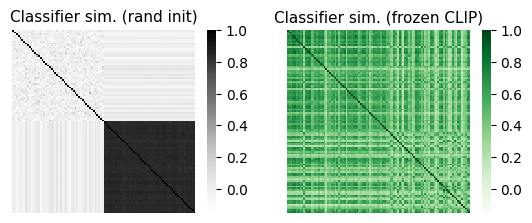

In [13]:
paths = [
    '../exps_sup/output/rn50_incap_supcls_bs256_fstail50ceil0',
    '../exps_sup/output/rn50_incap_supcls_bs256_fstail50ceil0_freezehead_in1k_clip_rn50_wit400m_a+cname',
    '../exps_sup/output/rn50_incap_supcls_bs1024_fstail50ceil0_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead',
]
num_tail_classes, num_head_classes_to_sample = 50, 50

sims = [get_classifier('{}/imagenet_val_features.pt'.format(path), num_tail_classes, num_head_classes_to_sample)[1] for path in paths]

fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))

sns.heatmap(sims[0], ax=ax[0], vmin=-.15, vmax=1, square=True, cmap='Greys', cbar=True, cbar_kws={"shrink": .79})
sns.heatmap(sims[1], ax=ax[1], vmin=-.15, vmax=1, square=True, cmap='Greens', cbar=True, cbar_kws={"shrink": .79})

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title('Classifier sim. (rand init)', fontsize=11, loc='center')
ax[1].set_title('Classifier sim. (frozen CLIP)', fontsize=11, loc='center')
plt.savefig('figs_new/tail_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()

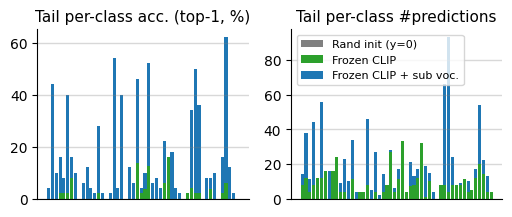

In [20]:
metrics = get_metrics(['{}/metrics/metrics_val_latest.pt'.format(path) for path in paths])
per_class_accs = [np.array(metric['per_class_accs'])[idxs] for metric in metrics]
per_class_preds = [np.array(metric['per_class_pred_cnt'])[idxs] for metric in metrics]

colors = ['gray', 'tab:green', 'tab:blue']
labels = ['Rand init (y=0)', 'Frozen CLIP', 'Frozen CLIP + sub voc.']
zorders = [3, 2, 1]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].set_box_aspect(.8)
ax[1].set_box_aspect(.8)

for i, (per_class_acc, per_class_pred) in enumerate(zip(per_class_accs, per_class_preds)):
    ax[0].bar(range(num_tail_classes), per_class_acc[-num_tail_classes:]*100, label=os.path.basename(labels[i]), color=colors[i], alpha=1, zorder=zorders[i])
    ax[1].bar(range(num_tail_classes), per_class_pred[-num_tail_classes:], label=os.path.basename(labels[i]), color=colors[i], alpha=1, zorder=zorders[i])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].yaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
ax[1].yaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_title('Tail per-class acc. (top-1, %)', fontsize=11)
ax[1].set_title('Tail per-class #predictions', fontsize=11)

plt.legend(fontsize=8, loc='upper left', frameon=True)
plt.savefig('figs_new/tail_bar.pdf', bbox_inches='tight', dpi=300)
plt.show()